In [101]:
import numpy as np
import matplotlib.pyplot as plt

data_train = np.load('data1/noisy_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


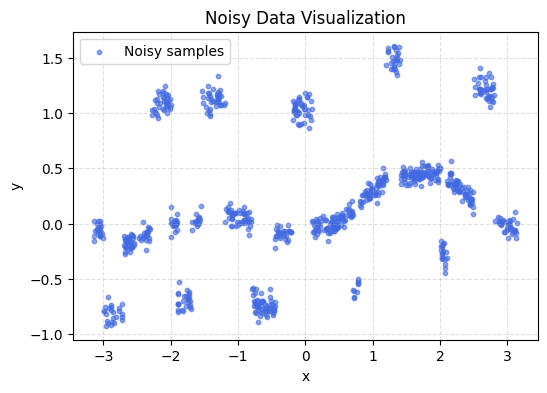

In [102]:
x_train_in = data_train["x"]
y_train_in = data_train["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_train_in, y_train_in, s=10, alpha=0.6, color="royalblue", label="Noisy samples")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

Keys in file: ['x', 'y']
x: shape = (800, 1)
y: shape = (800, 1)


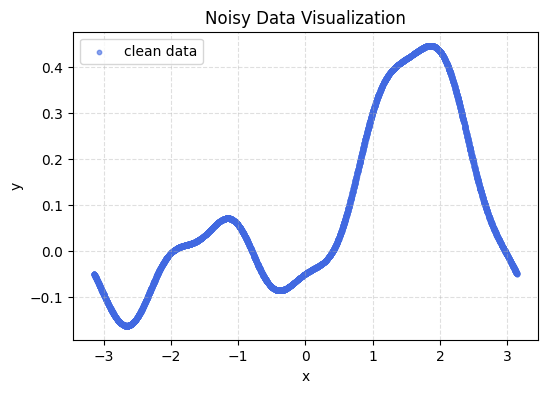

In [103]:
data_test = np.load('data1/clean_data.npz')

print("Keys in file:", data_train.files)
for key in data_train.files:
    print(f"{key}: shape = {data_train[key].shape}")

x_test = data_test["x"]
y_test = data_test["y"]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(x_test, y_test, s=10, alpha=0.6, color="royalblue", label="clean data")
plt.title("Noisy Data Visualization")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [104]:
import sys, torch, os, site
print("Python exe:", sys.executable)
print("torch file:", getattr(torch, "__file__", None))
print("has torch.version? ->", hasattr(torch, "version"))
print("User-site:", site.getusersitepackages())

Python exe: c:\Program Files\Python311\python.exe
torch file: C:\Users\mnhat\AppData\Roaming\Python\Python311\site-packages\torch\__init__.py
has torch.version? -> True
User-site: C:\Users\mnhat\AppData\Roaming\Python\Python311\site-packages


In [105]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
print("cuda in wheel:", torch.version.cuda)
from util import (
    get_torch_size_string,
    print_model_parameters,
    th2np,
)
from local_mdn import (
    MixtureDensityNetwork,
    gmm_forward,
    eval_mdn_1d,
)

2.5.1+cu121
cuda in wheel: 12.1


In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.version.cuda

'12.1'

In [107]:
# when you build the model (keep k=5 if you like)
mdn = MixtureDensityNetwork(
    name='mdn',
    x_dim=1, y_dim=1, k=5,
    h_dim_list=[64,64],
    actv=nn.SiLU(),
    sig_max=15.0,  # <= tighten
    mu_min=-0.01,      # <= widen (in normalized units)
    mu_max=+0.01,
    p_drop=0.0, use_bn=False,
).to(device)
mdn.init_param()
optm = torch.optim.Adam(mdn.parameters(), lr=3e-5, eps=1e-4, weight_decay=1e-4)
schd = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=0.9999)

In [108]:
n_train = 800
x_train = torch.from_numpy(x_train_in).to(device)
y_train = torch.from_numpy(y_train_in).to(device)

In [109]:
max_iter,batch_size,print_every,plot_every = 2e4,128,1000,5000
print ("max_iter:[%d] batch_size:[%d] print_every:[%d] plot_every:[%d]"%
      (max_iter,batch_size,print_every,plot_every))

max_iter:[20000] batch_size:[128] print_every:[1000] plot_every:[5000]


In [110]:
print ("Start training")
np.random.seed(seed=0)
torch.manual_seed(seed=0)
mdn.init_param()
mdn.train()

Start training


MixtureDensityNetwork(
  (actv): SiLU()
  (net): Sequential(
    (linear_00): Linear(in_features=1, out_features=64, bias=True)
    (silu_01): SiLU()
    (dropout1d_02): Dropout1d(p=0.0, inplace=False)
    (linear_03): Linear(in_features=64, out_features=64, bias=True)
    (silu_04): SiLU()
    (dropout1d_05): Dropout1d(p=0.0, inplace=False)
    (mixturesofgaussianlayer_06): MixturesOfGaussianLayer(
      (fc_pi): Linear(in_features=64, out_features=5, bias=True)
      (fc_mu): Linear(in_features=64, out_features=5, bias=True)
      (fc_sigma): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)

Start training
[   0/20000] loss:[3.568]


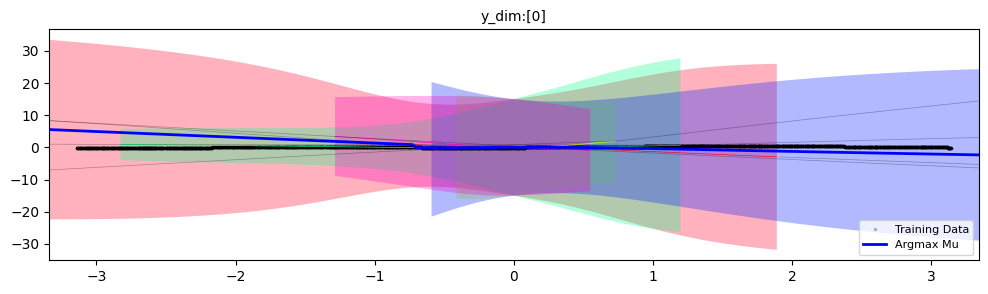

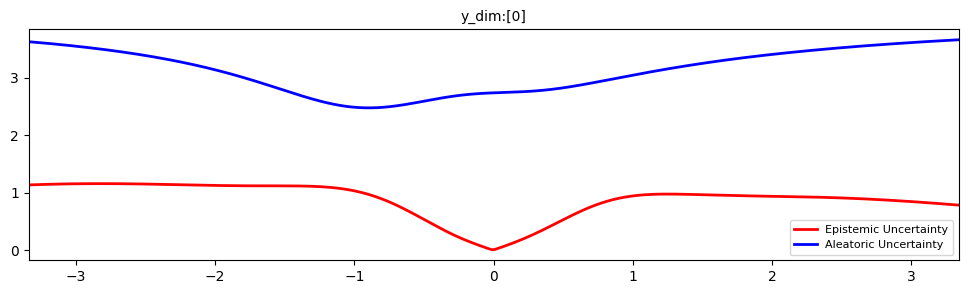

[1000/20000] loss:[1.544]
[2000/20000] loss:[1.387]
[3000/20000] loss:[1.161]
[4000/20000] loss:[0.978]
[5000/20000] loss:[0.929]


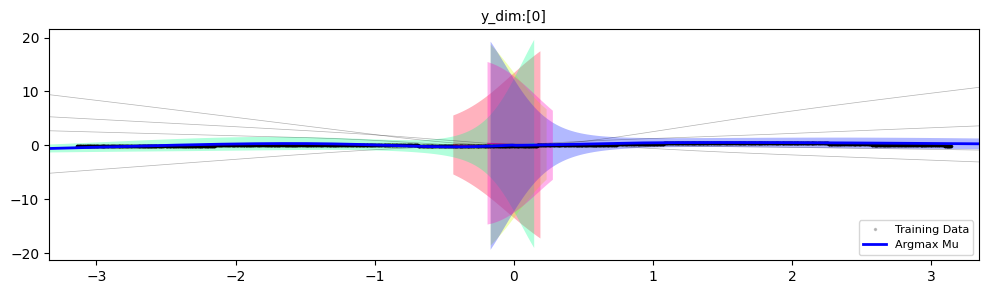

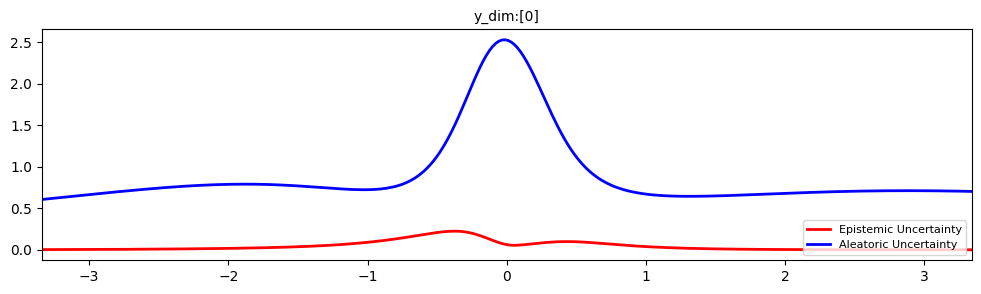

[6000/20000] loss:[0.817]
[7000/20000] loss:[0.921]
[8000/20000] loss:[0.852]
[9000/20000] loss:[0.864]
[10000/20000] loss:[0.759]


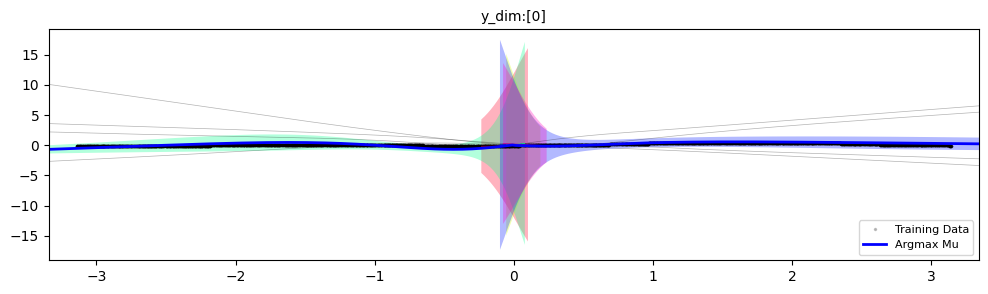

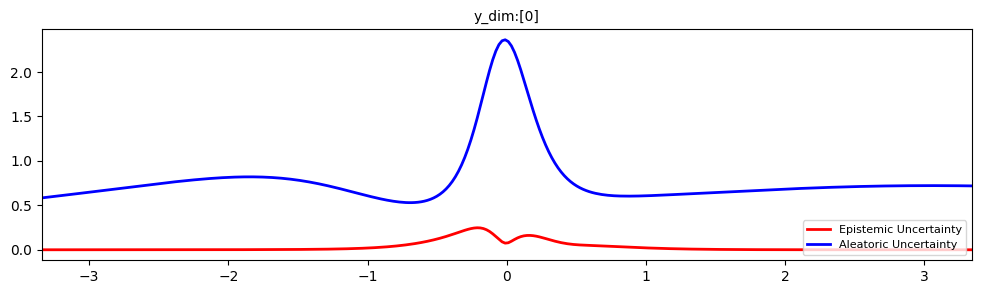

[11000/20000] loss:[0.848]
[12000/20000] loss:[0.776]
[13000/20000] loss:[0.800]
[14000/20000] loss:[0.766]
[15000/20000] loss:[0.699]


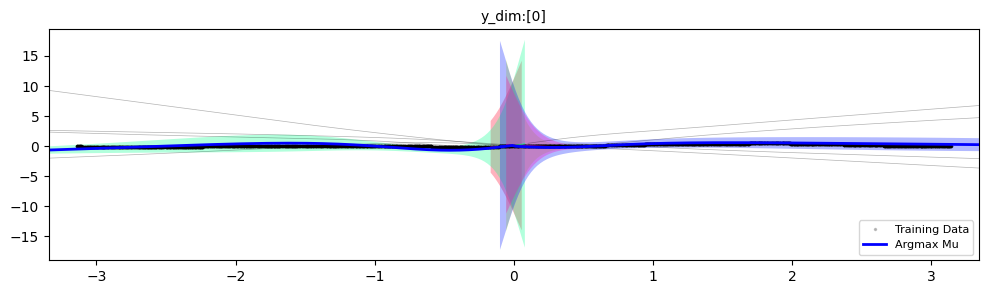

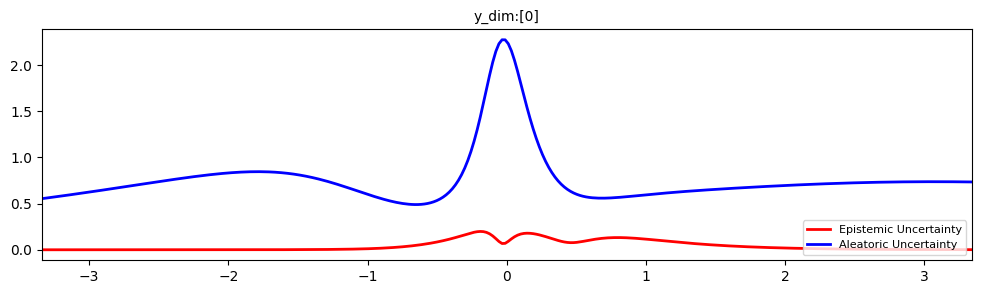

[16000/20000] loss:[0.724]
[17000/20000] loss:[0.780]
[18000/20000] loss:[0.700]
[19000/20000] loss:[0.650]
[19999/20000] loss:[0.756]


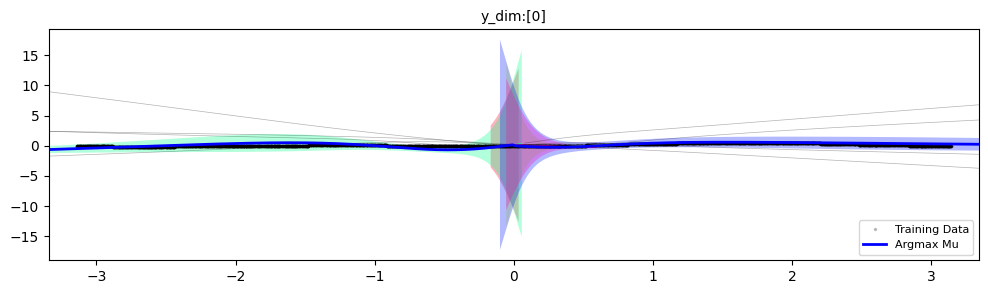

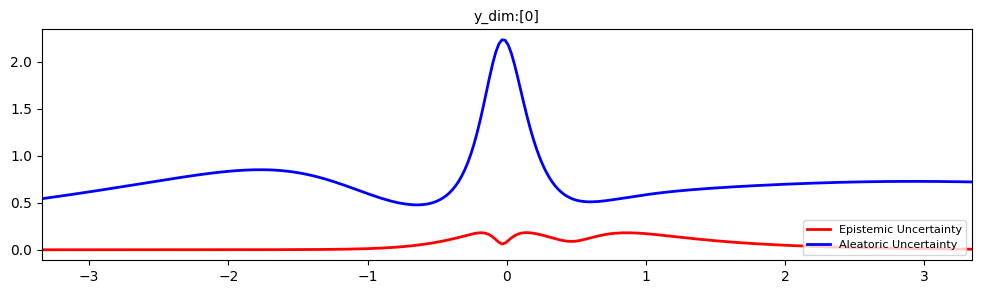

Done.


In [111]:
print ("Start training")
np.random.seed(seed=0)
torch.manual_seed(seed=0)
mdn.init_param()
mdn.train()
x_train = torch.Tensor(x_train_in).to(device)
y_train = torch.Tensor(y_train_in).to(device)

for it in range(int(max_iter)):
    batch_idx = np.random.permutation(n_train)[:batch_size]
    x_batch,y_batch = x_train[batch_idx],y_train[batch_idx]

    # Update
    mdn.zero_grad()
    pi_batch,mu_batch,sigma_batch = mdn.forward(x_batch)
    gmm_out = gmm_forward(pi_batch,mu_batch,sigma_batch,y_batch)
    loss = torch.mean(gmm_out['nlls']) + 0.1*F.mse_loss(y_batch,gmm_out['argmax_mu'])
    loss.backward()
    optm.step()
    schd.step()
    # Print
    if ((it%print_every)==0) or (it==(max_iter-1)):
        print ("[%4d/%d] loss:[%.3f]"%(it,max_iter,loss))

    # Plot
    if ((it%plot_every)==0) or (it==(max_iter-1)):
        eval_mdn_1d(mdn,x_test,y_test,figsize=(12,3),device=device)
print("Done.")
    
    # ... your print/plot stay unchanged ...




In [ ]:
from jit_wrap.py import save_jit_mode

jit

AttributeError: 'MixtureDensityNetwork' object has no attribute 'device'